# SUMMARY
Для задачи предсказания зароботной платы были проведены эксперименты со следующими моделями:
    
    1) SalaryPredictor - базовая модель со сверточными слоями, нормированием по слоям и эмбеддингами, инициализируемых случайно
    2) SalaryPredictorBatchNorm - с нормированием по батчам
    3) SalaryPredictorLayerNorm - с нормированием по слоям
    4) SalaryPredictorParallelConv - параллельные сверточные слои
    5) SalaryPredictorStackMoreLayers - с удвоенным количеством слоев
    6) SalaryPredictorEarlyStopping - базовая модель с остановкой обучения после 5 эпохи
    7) SalaryPredictorMaxPool - с пулингом максимального значения
    8) SalaryPredictorAvgPool - с пулингом усредненного значения
    9) SalaryPredictorPretrainedEmbeddings - с предобученными эмбеддингами *glove-wiki-gigaword-50*
    10) SalaryPredictorPretrainedEmbeddingsTrainedWeights - с предобученными эмбеддингами и их дообучением
    11) SalaryPredictorLSTM - со слоями LSTM вместо сверточных для текстовых признаков
    12) SalaryPredictorBidirectionalLSTM - с двунаправленными LSTM
    13) SalaryPredictorRandomForest - с ансамблем деревьев решений в качестве последнего слоя для SalaryPredictorLayerNorm
    14) SalaryPredictorSoftmaxPooling - с пулингом значений после функции Softmax
    15) SalaryPredictorAttentivePooling - с пулингом значений после функции Attention

***[Графики функции потерь и метрик MSE и MAE](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars)***

Лучшее качество показала модель со сверточными слоями, механизмом внимания и эмбеддингами, инициализируемых случайно (***SalaryPredictorAttentivePooling***) - MSE **0.024**.
Некоторые другие модели показали качество немногим хуже, но все еще очень хорошее MSE 0.027:
* с нормированием SalaryPredictorBatchNorm и SalaryPredictorLayerNorm
* с предобученными эмбеддингами и их дообучением (*SalaryPredictorPretrainedEmbeddingsTrainedWeights*)
* сеть с двунаправленными реккурентными слоями для обработки текстовых признаков (*SalaryPredictorBidirectionalLSTM*)

Все модели имели поведение на обучении похожее между собой (см. графики), кроме:
* базовой модели *SalaryPredictor*, которая имеет более долгую и плавную сходимость
* модели с большим количеством слоев *SalaryPredictorStackMoreLayers*, которая дольше сходилась из-за большого количества параметров
* модели с параллельными свертками *SalaryPredictorParallelConv* - также из-за большего числа параметров и возросшей сложности
* и ансамбля из деревьев решений в качестве регрессионнного слоя *SalaryPredictorRandomForest* и признаков из обученной сети, которые сошлись моментально

Для обучения базовой модели необходимо **5** эпох (см. *SalaryPredictorEarlyStopping*)

# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [ ]:
import zipfile

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('job-salary-prediction', path='.')

with zipfile.ZipFile('job-salary-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('job-salary-prediction')
with zipfile.ZipFile('job-salary-prediction/Train_rev1.zip', 'r') as zip_ref:
    zip_ref.extractall('job-salary-prediction/Train_rev1')
with zipfile.ZipFile('job-salary-prediction/Test_rev1.zip', 'r') as zip_ref:
    zip_ref.extractall('job-salary-prediction/Test_rev1')

In [2]:
data = pd.read_csv("job-salary-prediction/Train_rev1/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

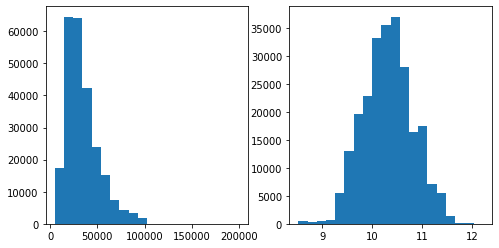

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
24695,67745996,RMN's required Maidstone,"We have RMN vacancies at Glenhurst Lodge, an i...",Maidstone,Maidstone,full_time,NaN,Glen Care Group,Healthcare & Nursing Jobs,"21,259 - 26,657/Year",23958,staffnurse.com,10.084100
76525,69007545,Vocational Instructor of Electrical Engineering,A Technical Training provider is looking for a...,"Middlesbrough, North Yorkshire",Middlesbrough,NaN,permanent,Alderwood Education,Teaching Jobs,26179/annum,26179,cv-library.co.uk,10.172751
30763,68065790,Motor Vehicle Technician fully qualifed,The market leading vehicle hire company by fle...,Aberdeen Aberdeenshire Scotland,Aberdeen,NaN,permanent,Northgate,Other/General Jobs,"From 23,290 to 23,290 per annum",23290,totaljobs.com,10.055822


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import re

def tokenize(text):
    return ' '.join(re.findall('\w+', text.lower()))

data[text_columns] = data[text_columns].applymap(tokenize)

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller simulation analyst operation'
assert data["Title"][54321] == 'international digital account manager german'

Tokenized:
2         mathematical modeller simulation analyst opera...
100002    a successful and high achieving specialist sch...
200002    web designer html css javascript photoshop ill...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter

token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 201698
('and', 2657388)
('the', 2080994)
('to', 2019884)
('a', 1521925)
('of', 1426213)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


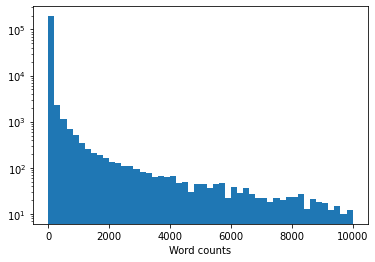

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 33816
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=8):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec i engineer

Matrix:
[[10527 29881  1886     1     1     1     1     1]
 [14740  2564     1     1     1     1     1     1]
 [27365  9921 14935 10524     1     1     1     1]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size =", len(data_train))
print("Validation size =", len(data_val))

Train size = 220291
Validation size = 24477


In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_lens=(8, 64), word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {"Title": as_matrix(data["Title"].values, max_lens[0]),
             "FullDescription": as_matrix(data["FullDescription"].values, max_lens[1]),
             'Categorical': categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))}

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3])

{'Title': tensor([[27365, 26706,  1307, 10912,  1420,     1,     1,     1],
         [27000, 13370, 30129,  2564,     1,     1,     1,     1],
         [ 4706,  8803, 18584,     1,     1,     1,     1,     1]]),
 'FullDescription': tensor([[32657, 30820, 33384, 12307,   702, 17473, 10912,  1413,  7830, 32980,
          13966,  1862, 11120, 21676, 12307,  1862, 10912,  1420, 30820, 16618,
            702,  9800, 29453,  1909, 13565, 10912,  1413, 15274, 21525, 21354,
          21929,  4745, 21382, 30466, 29453, 26706,  1307, 33155,  3362, 11283,
           1909, 31990, 30820,   981,  1909, 11110, 30026, 33286, 10912,  1413,
          11278,  2409,   702, 26706,  1307, 20543, 33483,  3362, 25729, 12307,
          30567, 26341, 26706, 20544],
         [ 2292, 33716,   702, 13370, 33274,   702,   223, 21741, 27000,  3267,
           8465,  9332, 33716, 13966,   702, 29272,   837, 25078,  2640, 12962,
           1909,  1594, 33483, 33716, 17797, 30820, 12806, 11278, 33409,  2409,
          

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn

In [23]:
class SalaryPredictor(nn.Module):
    def __init__(self,
                 n_tokens=len(tokens),
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=8):
        super().__init__()
        self.hid_size = hid_size
        self.n_tokens = n_tokens
        self.n_cat_features = n_cat_features

        self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 2),
            nn.ReLU(),
            nn.Linear(self.hid_size * 2, self.hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [25]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [24]:
from tqdm.notebook import trange

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, tqdm=True, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        id_range = trange(0, len(indices), batch_size) if tqdm else range(0, len(indices), batch_size)
        for start in id_range:
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle:
            break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [25]:
BATCH_SIZE = 128
VECTOR_SIZES = (8, 64)
EPOCHS = 3
DEVICE = torch.device('cpu')

In [26]:
def metrics(model, data, batch_size=BATCH_SIZE, **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, tqdm=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    return mse, mae

In [27]:
from torch.utils.tensorboard import SummaryWriter

def train(model, batch_size, epochs, device, vector_sizes, logdir='.'):
    writer = SummaryWriter(log_dir=f'runs/{logdir}')
    model = model.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    one_epoch_n_iterates = len(data_train) / batch_size

    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        for i, batch in enumerate(
                iterate_minibatches(data_train, batch_size=batch_size, device=device, max_lens=vector_sizes)):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            writer.add_scalar(f'train/loss', loss.item(), i + epoch * one_epoch_n_iterates)

            if i % 100 == 99:
                mse, mae = metrics(model, data_val, batch_size=batch_size, device=device, max_lens=vector_sizes)
                writer.add_scalar(f'val/Mean square error', mse,
                                  i + epoch * one_epoch_n_iterates)
                writer.add_scalar(f'val/Mean absolute error', mae,
                                  i + epoch * one_epoch_n_iterates)
        print(f'Train Loss {loss.item():.4f}')
        print(f'Mean square error {mse:.4f}')
        print(f'Mean absolute error {mae:.4f}')

model = SalaryPredictor()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictor')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.2450
Mean square error 0.3443
Mean absolute error 0.2767
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1246
Mean square error 0.1699
Mean absolute error 0.1881
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.2725
Mean square error 0.1086
Mean absolute error 0.1460


**Выводы:** Salary Predictor - baseline (1 сверточный слой + dropout) для задачи, сходится достаточно хорошо и быстро при 8 нейронах в скрытых слоях, за 3 эпохи MSE падает до **0.11**.
[Графики для Salary Predictor.](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOnRydWUsIlNhbGFyeVByZWRpY3RvckF0dGVudGl2ZVBvb2xpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdmdQb29sIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQmF0Y2hOb3JtIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQmlkaXJlY3Rpb25hbExTVE0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JFYXJseVN0b3BwaW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTFNUTSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckxheWVyTm9ybSI6ZmFsc2UsIlNhbGFyeVByZWRpY3Rvck1heFBvb2wiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQYXJhbGxlbENvbnYiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5ncyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclByZXRyYWluZWRFbWJlZGRpbmdzVHJhaW5lZFdlaWdodHMiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JSYW5kb21Gb3Jlc3QiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JTb2Z0bWF4UG9vbGluZyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclN0YWNrTW9yZUxheWVycyI6ZmFsc2V9)

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано.

Как модель ведет себя в зависимости от количества обучаемых параметров?

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdHRlbnRpdmVQb29saW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQXZnUG9vbCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJhdGNoTm9ybSI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yQmlkaXJlY3Rpb25hbExTVE0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JFYXJseVN0b3BwaW5nIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JMU1RNIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTGF5ZXJOb3JtIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JNYXhQb29sIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUGFyYWxsZWxDb252Ijp0cnVlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5ncyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclByZXRyYWluZWRFbWJlZGRpbmdzVHJhaW5lZFdlaWdodHMiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JSYW5kb21Gb3Jlc3QiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JTb2Z0bWF4UG9vbGluZyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclN0YWNrTW9yZUxheWVycyI6dHJ1ZX0%3D):**
    
    1) Нормализация заметно улучшает сходимость (см. графики), несмотря на большую ошибку в начале. За 3 эпохи MSE уменьшается до **0.027** для BatchNorm и LayerNorm. С LayerNorm обучение проходит немного лучше.
    2) Параллельные сверточные слои не влияют существенно на процесс обучения модели. MSE **0.08**.
    3) Больше слоев также добавляет еще большую сложность, слишком усложняя модель для текущей задачи. Минимальный MSE **0.11**. Большая сложность ведет к переобучению - уже на 3 эпохе ошибка начинает расти.
    4) Ранняя остановка показывает необходимое кол-во эпох. **5** эпох необходимо для baseline модели, чтобы достигнуть инимальный MSE **0.10**.


In [30]:
class SalaryPredictorNorm(SalaryPredictor):
    def __init__(self, is_layer_norm=False):
        super().__init__()
        self.is_layer_norm = is_layer_norm

        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            self.layer_norm(self.hid_size, 8-1),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            self.layer_norm(self.hid_size, 64-1),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 2),
            self.layer_norm(self.hid_size * 2, 0),
            nn.ReLU(),
            nn.Linear(self.hid_size * 2, self.hid_size * 2),
            self.layer_norm(self.hid_size * 2, 0),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            self.layer_norm(self.hid_size, 0),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def layer_norm(self, a, b):
        if self.is_layer_norm:
            if b:
                return nn.LayerNorm([a, b])
            return nn.LayerNorm(a)
        return nn.BatchNorm1d(a)

model = SalaryPredictorNorm()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorBatchNorm')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 2.7002
Mean square error 0.0425
Mean absolute error 0.0809
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1186
Mean square error 0.0349
Mean absolute error 0.0726
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.3912
Mean square error 0.0272
Mean absolute error 0.0629


In [34]:
model_norm = SalaryPredictorNorm(is_layer_norm=True)
train(model_norm, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorLayerNorm')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1890
Mean square error 0.0607
Mean absolute error 0.0989
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0565
Mean square error 0.0360
Mean absolute error 0.0732
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.2655
Mean square error 0.0274
Mean absolute error 0.0625


In [33]:
class SalaryPredictorParallelConv(SalaryPredictor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 6, self.hid_size * 4),
            nn.ReLU(),
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_1 = self.title_encoder(title_embeddings).squeeze()
        title_features_2 = self.title_encoder(title_embeddings).squeeze()
        title_features = torch.cat([title_features_1, title_features_2], dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_1 = self.description_encoder(description_embeddings).squeeze()
        description_features_2 = self.description_encoder(description_embeddings).squeeze()
        description_features = torch.cat([description_features_1, description_features_2], dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

model = SalaryPredictorParallelConv()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorParallelConv')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0664
Mean square error 0.1305
Mean absolute error 0.1580
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0575
Mean square error 0.0650
Mean absolute error 0.1051
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1804
Mean square error 0.0838
Mean absolute error 0.1251


In [35]:
class SalaryPredictorStackMoreLayers(SalaryPredictor):
    def __init__(self):
        super().__init__()
        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=5),
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=5),
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 4),
            nn.ReLU(),
            nn.Linear(self.hid_size * 4, self.hid_size * 2),
            nn.ReLU(),
            nn.Linear(self.hid_size * 2, self.hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size * 2),
            nn.ReLU(),
            nn.Linear(self.hid_size * 2, self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

model = SalaryPredictorStackMoreLayers()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorStackMoreLayers')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0759
Mean square error 0.1151
Mean absolute error 0.1462
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1443
Mean square error 0.0829
Mean absolute error 0.1213
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0767
Mean square error 0.0723
Mean absolute error 0.1133


In [36]:
def train_early_stopping(model, batch_size, epochs, device, vector_sizes, logdir='.', patience=1, epsilon=0.02):
    writer = SummaryWriter(log_dir=f'runs/{logdir}')
    model = model.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    one_epoch_n_iterates = len(data_train) / batch_size

    mae_list = []
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        for i, batch in enumerate(
                iterate_minibatches(data_train, batch_size=batch_size, device=device, max_lens=vector_sizes)):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            writer.add_scalar(f'train/loss', loss.item(), i + epoch * one_epoch_n_iterates)

            if i % 100 == 99:
                mse, mae = metrics(model, data_val, batch_size=batch_size, device=device, max_lens=vector_sizes)
                writer.add_scalar(f'val/Mean square error', mse, i + epoch * one_epoch_n_iterates)
                writer.add_scalar(f'val/Mean absolute error', mae, i + epoch * one_epoch_n_iterates)
        print(f'Train Loss {loss.item():.4f}')
        print(f'Mean square error {mse:.4f}')
        print(f'Mean absolute error {mae:.4f}')
        if len(mae_list) < patience:
            mae_list.append(mae)
        else:
            for val in mae_list:
                if val - mae > epsilon:
                    mae_list = mae_list[1:] + [mae]
                    break
            else:
                print(f'Early stopping after epoch {epoch}')
                break

model = SalaryPredictor()
train_early_stopping(model, batch_size=BATCH_SIZE, epochs=10,
                     device=DEVICE, vector_sizes=VECTOR_SIZES,
                     logdir='SalaryPredictorEarlyStopping')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0756
Mean square error 0.4523
Mean absolute error 0.3210
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1481
Mean square error 0.2803
Mean absolute error 0.2501
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1566
Mean square error 0.1592
Mean absolute error 0.1829
Epoch 3


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0393
Mean square error 0.1228
Mean absolute error 0.1582
Epoch 4


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.1612
Mean square error 0.0966
Mean absolute error 0.1377
Epoch 5


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0146
Mean square error 0.1033
Mean absolute error 0.1442
Early stopping after epoch 5


**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

**Pooling** слой уменьшает размер слоя и помогает извлечь только значимые признаки, выбирая максимальное (MaxPool) значение или усредняя все значения (AvgPool) в рамках заданного окна.

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOnRydWUsIlNhbGFyeVByZWRpY3RvckF0dGVudGl2ZVBvb2xpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdmdQb29sIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JCYXRjaE5vcm0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JCaWRpcmVjdGlvbmFsTFNUTSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckVhcmx5U3RvcHBpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JMU1RNIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTGF5ZXJOb3JtIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTWF4UG9vbCI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yUGFyYWxsZWxDb252IjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUHJldHJhaW5lZEVtYmVkZGluZ3MiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5nc1RyYWluZWRXZWlnaHRzIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUmFuZG9tRm9yZXN0IjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yU29mdG1heFBvb2xpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JTdGFja01vcmVMYXllcnMiOmZhbHNlfQ%3D%3D):**
Pooling особо не влияет на качество модели (CNN с BatchNorm). Для MaxPool и AvgPool MSE **0.03**.

In [50]:
class SalaryPredictorPooling(SalaryPredictor):
    def __init__(self, is_max_pool=False, dim=8):
        super().__init__()
        self.is_max_pool = is_max_pool
        self.dim = dim

        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            self.pooling_layer(output_size=4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            self.pooling_layer(output_size=4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 16),
            nn.BatchNorm1d(self.hid_size * 16),
            self.pooling_layer(output_size=self.hid_size * 8),
            nn.ReLU(),
            nn.Linear(self.hid_size * 8, self.hid_size * 4),
            nn.BatchNorm1d(self.hid_size * 4),
            self.pooling_layer(output_size=self.hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.BatchNorm1d(self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def pooling_layer(self, output_size):
        if self.is_max_pool:
            return nn.AdaptiveMaxPool1d(output_size=output_size)
        return nn.AdaptiveAvgPool1d(output_size=output_size)

model = SalaryPredictorPooling(is_max_pool=True)
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorMaxPool')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 1.3435
Mean square error 0.0401
Mean absolute error 0.0771
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.9649
Mean square error 0.0341
Mean absolute error 0.0710
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 2.2461
Mean square error 0.0297
Mean absolute error 0.0660


In [29]:
model = SalaryPredictorPooling()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorAvgPool')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 3.6169
Mean square error 0.0482
Mean absolute error 0.0831
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 3.3580
Mean square error 0.0331
Mean absolute error 0.0698
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 11.9864
Mean square error 0.0307
Mean absolute error 0.0668


**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdHRlbnRpdmVQb29saW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQXZnUG9vbCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJhdGNoTm9ybSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJpZGlyZWN0aW9uYWxMU1RNIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yRWFybHlTdG9wcGluZyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckxTVE0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JMYXllck5vcm0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JNYXhQb29sIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JQYXJhbGxlbENvbnYiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5ncyI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yUHJldHJhaW5lZEVtYmVkZGluZ3NUcmFpbmVkV2VpZ2h0cyI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yUmFuZG9tRm9yZXN0IjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yU29mdG1heFBvb2xpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JTdGFja01vcmVMYXllcnMiOmZhbHNlfQ%3D%3D):**
    
    1) В эмбеддингах, инициализируемых случайно (SalaryPredictorMaxPool) MSE 0.03, а в предобученных **0.037** и **0.027** с замороженными и обучаемыми весами соответственно.
    2) Если помимо обучения модели, еще и дообучать большие эмбеддинги, то время обучения увеличивается в разы, что неудобно и требует GPU, при этом качество увеличивается незначительно.

In [48]:
import gensim.downloader as api

class SalaryPredictorPretrainedEmbeddings(SalaryPredictorPooling):
    def __init__(self, pretrained_embedding, freeze=True, **kwargs):
        super().__init__(**kwargs)
        self.embedder = nn.Embedding.from_pretrained(torch.Tensor(pretrained_embedding), freeze=freeze)

embed = api.load('glove-wiki-gigaword-50')
model = SalaryPredictorPretrainedEmbeddings(embed.vectors, dim=50, is_max_pool=True)
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorPretrainedEmbeddings')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 5.1737
Mean square error 0.0509
Mean absolute error 0.0859
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 1.8640
Mean square error 0.0435
Mean absolute error 0.0794
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 3.3003
Mean square error 0.0373
Mean absolute error 0.0744


In [49]:
model = SalaryPredictorPretrainedEmbeddings(embed.vectors, freeze=False, dim=50, is_max_pool=True)
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorPretrainedEmbeddingsTrainedWeights')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 9.0926
Mean square error 0.0368
Mean absolute error 0.0741
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 2.0870
Mean square error 0.0277
Mean absolute error 0.0634
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 1.0606
Mean square error 0.0270
Mean absolute error 0.0633


**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdHRlbnRpdmVQb29saW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQXZnUG9vbCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJhdGNoTm9ybSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJpZGlyZWN0aW9uYWxMU1RNIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JFYXJseVN0b3BwaW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTFNUTSI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yTGF5ZXJOb3JtIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JNYXhQb29sIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUGFyYWxsZWxDb252IjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUHJldHJhaW5lZEVtYmVkZGluZ3MiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5nc1RyYWluZWRXZWlnaHRzIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUmFuZG9tRm9yZXN0IjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yU29mdG1heFBvb2xpbmciOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JTdGFja01vcmVMYXllcnMiOmZhbHNlfQ%3D%3D):**
    
    1) В целом, рекурентные сети работают хуже, чем сверточные в данной задаче.
    2) Однонаправленная сеть показывает качество немногим хуже, чем двунаправленная, MSE **0.046** и **0.027** соответственно.
    3) Лучшее сочетание рекурентных и сверточных сетей - использовать только один слой LSTM, так как задача не требует большой и сложной модели.

In [53]:
class SalaryPredictorLSTM(SalaryPredictor):
    def __init__(self, bidirectional=False):
        super().__init__()

        self.LSTM = nn.LSTM(self.hid_size, self.hid_size, bidirectional=bidirectional)

        self.title_encoder = nn.Sequential(
            nn.BatchNorm1d(self.hid_size * 2 if bidirectional else self.hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder = nn.Sequential(
            nn.BatchNorm1d(self.hid_size * 2 if bidirectional else self.hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 4),
            nn.BatchNorm1d(self.hid_size * 4),
            nn.ReLU(),
            nn.Linear(self.hid_size * 4, self.hid_size * 2),
            nn.BatchNorm1d(self.hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * (6 if bidirectional else 4), self.hid_size),
            nn.BatchNorm1d(self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        title_lstm, hidden = self.LSTM(title_embeddings)
        title_features = self.title_encoder(title_lstm.permute(0, 2, 1)).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_lstm, hidden = self.LSTM(description_embeddings)
        description_features = self.title_encoder(description_lstm.permute(0, 2, 1)).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

model = SalaryPredictorLSTM()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorLSTM')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 1.2841
Mean square error 0.2752
Mean absolute error 0.2342
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 2.7300
Mean square error 0.0937
Mean absolute error 0.1223
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.8173
Mean square error 0.0464
Mean absolute error 0.0834


In [56]:
model = SalaryPredictorLSTM(bidirectional=True)
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorBidirectionalLSTM')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.9477
Mean square error 0.0443
Mean absolute error 0.0828
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 5.4459
Mean square error 0.0319
Mean absolute error 0.0693
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.7884
Mean square error 0.0272
Mean absolute error 0.0627


**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdHRlbnRpdmVQb29saW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQXZnUG9vbCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJhdGNoTm9ybSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckJpZGlyZWN0aW9uYWxMU1RNIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yRWFybHlTdG9wcGluZyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckxTVE0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JMYXllck5vcm0iOnRydWUsIlNhbGFyeVByZWRpY3Rvck1heFBvb2wiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQYXJhbGxlbENvbnYiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JQcmV0cmFpbmVkRW1iZWRkaW5ncyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclByZXRyYWluZWRFbWJlZGRpbmdzVHJhaW5lZFdlaWdodHMiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JSYW5kb21Gb3Jlc3QiOnRydWUsIlNhbGFyeVByZWRpY3RvclNvZnRtYXhQb29saW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yU3RhY2tNb3JlTGF5ZXJzIjpmYWxzZX0%3D):**
   
    1) Ансамбль деревьев решений в качестве регрессора работает также (MSE **0.028**), чем лучшая нейросеть (с нормированием по слоям SalaryPredictorLayerNorm MSE 0.027).
    2) Лес деревьев очень быстро сходится к малым значениям ошибки.

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchvision.models.feature_extraction import create_feature_extractor

def train_tree_ensemble(model, regressor, batch_size, epochs, device, vector_sizes, logdir='.'):
    writer = SummaryWriter(log_dir=f'runs/{logdir}')
    model = model.to(device)
    one_epoch_n_iterates = len(data_train) / batch_size

    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        for i, batch in enumerate(
                iterate_minibatches(data_train, batch_size=batch_size, device=device, max_lens=vector_sizes)):
            features = model(batch)['layer'].detach().cpu().numpy()
            regressor.fit(features, batch[TARGET_COLUMN])
            pred = regressor.predict(features)
            loss = mean_squared_error(batch[TARGET_COLUMN], pred)
            writer.add_scalar(f'train/loss', loss, i + epoch * one_epoch_n_iterates)

            if i % 100 == 99:
                mse, mae = metrics_forest(model, regressor, data_val, batch_size=batch_size, device=device, max_lens=vector_sizes)
                writer.add_scalar(f'val/Mean square error', mse, i + epoch * one_epoch_n_iterates)
                writer.add_scalar(f'val/Mean absolute error', mae, i + epoch * one_epoch_n_iterates)
        print(f'Train Loss {loss:.4f}')
        print(f'Mean square error {mse:.4f}')
        print(f'Mean absolute error {mae:.4f}')
    return regressor

def metrics_forest(model, regressor, data, batch_size=BATCH_SIZE, **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, tqdm=False, **kw):
        features = model(batch)['layer'].detach().cpu().numpy()
        batch_pred = regressor.predict(features)
        squared_error += mean_squared_error(batch[TARGET_COLUMN], batch_pred)
        abs_error += mean_absolute_error(batch[TARGET_COLUMN], batch_pred)
        num_samples += len(batch)
    mse = squared_error / num_samples
    mae = abs_error / num_samples
    return mse, mae


model_no_last_layer = create_feature_extractor(model_norm, return_nodes={'final_predictor.2': 'layer'})
regr = RandomForestRegressor(n_estimators=5, max_depth=2, random_state=0)
regr = train_tree_ensemble(model_no_last_layer, regr, batch_size=BATCH_SIZE, epochs=3,
                           device=DEVICE, vector_sizes=VECTOR_SIZES, logdir='SalaryPredictorRandomForest')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0307
Mean square error 0.0302
Mean absolute error 0.0667
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0935
Mean square error 0.0293
Mean absolute error 0.0658
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.0034
Mean square error 0.0279
Mean absolute error 0.0640


**6. Pooling слои *продвинутые* (3 балла)**

Реализуйте и примените
Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.

**Выводы и [Графики](https://tensorboard.dev/experiment/sOyIrKlBRTGmYkrSvh9p4g/#scalars&runSelectionState=eyJTYWxhcnlQcmVkaWN0b3IiOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JBdHRlbnRpdmVQb29saW5nIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JBdmdQb29sIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQmF0Y2hOb3JtIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yQmlkaXJlY3Rpb25hbExTVE0iOmZhbHNlLCJTYWxhcnlQcmVkaWN0b3JFYXJseVN0b3BwaW5nIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yTFNUTSI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvckxheWVyTm9ybSI6dHJ1ZSwiU2FsYXJ5UHJlZGljdG9yTWF4UG9vbCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclBhcmFsbGVsQ29udiI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclByZXRyYWluZWRFbWJlZGRpbmdzIjpmYWxzZSwiU2FsYXJ5UHJlZGljdG9yUHJldHJhaW5lZEVtYmVkZGluZ3NUcmFpbmVkV2VpZ2h0cyI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclJhbmRvbUZvcmVzdCI6ZmFsc2UsIlNhbGFyeVByZWRpY3RvclNvZnRtYXhQb29saW5nIjp0cnVlLCJTYWxhcnlQcmVkaWN0b3JTdGFja01vcmVMYXllcnMiOmZhbHNlfQ%3D%3D):**
Продвинутые методы пулинга помогают значительно улучшать качество сети. MSE **0.05** и **0.024** для Softmax и Attentive Pooling соотвественно.

In [58]:
class SalaryPredictorSoftmaxPooling(SalaryPredictor):
    def __init__(self, dim=8):
        super().__init__()
        self.dim = dim

        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            nn.Softmax(dim=2),
            nn.AdaptiveAvgPool1d(output_size=4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Softmax(dim=2),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            nn.Softmax(dim=2),
            nn.AdaptiveAvgPool1d(output_size=4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Softmax(dim=2),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 16),
            nn.BatchNorm1d(self.hid_size * 16),
            nn.Softmax(dim=1),
            nn.AdaptiveAvgPool1d(output_size=self.hid_size * 8),
            nn.ReLU(),
            nn.Linear(self.hid_size * 8, self.hid_size * 4),
            nn.BatchNorm1d(self.hid_size * 4),
            nn.Softmax(dim=1),
            nn.AdaptiveAvgPool1d(output_size=self.hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.BatchNorm1d(self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

model = SalaryPredictorSoftmaxPooling()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorSoftmaxPooling')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 4.4157
Mean square error 0.0420
Mean absolute error 0.0804
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.2501
Mean square error 0.0486
Mean absolute error 0.0858
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.9460
Mean square error 0.0658
Mean absolute error 0.1042


In [59]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.U = nn.Parameter(torch.randn(hidden_size, hidden_size))

    def forward(self, A, B):
        G = A.transpose(-1, -2) @ self.U.expand(A.shape[0], -1, -1) @ B
        G = torch.tanh(G)
        A_pooling = G.max(dim=-1)[0]
        B_pooling = G.max(dim=-2)[0]
        A_pooling = A_pooling.softmax(dim=-1)
        B_pooling = B_pooling.softmax(dim=-1)
        ra = A @ A_pooling.unsqueeze(-1)
        rb = B @ B_pooling.unsqueeze(-1)
        ra = ra.squeeze(-1)
        rb = rb.squeeze(-1)
        return ra, rb

class SalaryPredictorAttentivePooling(SalaryPredictor):
    def __init__(self, dim=8):
        super().__init__()
        self.dim = dim

        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.dim, self.hid_size, kernel_size=(2, )),
            nn.BatchNorm1d(self.hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )
        self.attentive_pooling = Attention(self.hid_size)
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 8),
            nn.BatchNorm1d(self.hid_size * 8),
            nn.ReLU(),
            nn.Linear(self.hid_size * 8, self.hid_size * 4),
            nn.BatchNorm1d(self.hid_size * 4),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 6, self.hid_size),
            nn.BatchNorm1d(self.hid_size),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        colmax, rowmax = self.attentive_pooling(title_features, description_features)
        features = torch.cat(
            [colmax.squeeze(), rowmax.squeeze(), categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

model = SalaryPredictorAttentivePooling()
train(model, BATCH_SIZE, EPOCHS, DEVICE, VECTOR_SIZES, 'SalaryPredictorAttentivePooling')

Epoch 0


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 0.7478
Mean square error 0.0347
Mean absolute error 0.0719
Epoch 1


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 11.0152
Mean square error 0.0271
Mean absolute error 0.0627
Epoch 2


  0%|          | 0/1722 [00:00<?, ?it/s]

Train Loss 5.1260
Mean square error 0.0241
Mean absolute error 0.0589
